In [ ]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw09.ok')

# Homework 9: Linear Regression

**Helpful Resource:**
- [Python Reference](https://math-121-spring-21.github.io/python-reference.html): Cheat sheet of helpful array & table methods used in Math 121!

**Reading**: 
* [Linear Regression](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html)
* [Method of Least Squares](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html)
* [Least Squares Regression](https://www.inferentialthinking.com/chapters/15/4/Least_Squares_Regression.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

For all problems that you must write explanations and sentences for, you **must** provide your answer in the designated space. **Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook!** For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!

In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.",
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

from client.api.notebook import *
def new_save_notebook(self):
    """ Saves the current notebook by
        injecting JavaScript to save to .ipynb file.
    """
    try:
        from IPython.display import display, Javascript
    except ImportError:
        log.warning("Could not import IPython Display Function")
        print("Make sure to save your notebook before sending it to OK!")
        return

    if self.mode == "jupyter":
        display(Javascript('IPython.notebook.save_checkpoint();'))
        display(Javascript('IPython.notebook.save_notebook();'))
    elif self.mode == "jupyterlab":
        display(Javascript('document.querySelector(\'[data-command="docmanager:save"]\').click();'))   

    print('Saving notebook...', end=' ')

    ipynbs = [path for path in self.assignment.src
              if os.path.splitext(path)[1] == '.ipynb']
    # Wait for first .ipynb to save
    if ipynbs:
        if wait_for_save(ipynbs[0]):
            print("Saved '{}'.".format(ipynbs[0]))
        else:
            log.warning("Timed out waiting for IPython save")
            print("Could not automatically save \'{}\'".format(ipynbs[0]))
            print("Make sure your notebook"
                  " is correctly named and saved before submitting to OK!".format(ipynbs[0]))
            return False                
    else:
        print("No valid file sources found")
    return True

def wait_for_save(filename, timeout=600):
    """Waits for FILENAME to update, waiting up to TIMEOUT seconds.
    Returns True if a save was detected, and False otherwise.
    """
    modification_time = os.path.getmtime(filename)
    start_time = time.time()
    while time.time() < start_time + timeout:
        if (os.path.getmtime(filename) > modification_time and
            os.path.getsize(filename) > 0):
            return True
        time.sleep(0.2)
    return False

Notebook.save_notebook = new_save_notebook

ok = Notebook('hw09.ok')

Assignment: Homework 9: Linear Regression
OK, version v1.18.1



Before continuing the assignment, save your work and then execute the submit cell below. The result will contain a link that you can use to check that your assignment has been submitted successfully. If you submit more than once before the deadline, we will only grade your final submission. If you mistakenly submit the wrong one, you can head to okpy.org and flag the correct version. There will be another submit cell at the end of the assignment when you finish!

In [2]:
_ = ok.submit()

## 1. Exploring the PTEN Gene with Linear Regression


### A Quick Review of Standard Units

**Question 0**

Image A | Image B
:-:| :-:
![one](normal2.png) | ![two](normal1.png)


Two normal distributions, Distribution 1 and Distribution 2, were generated, each with a different mean and standard deviation. Which image above corresponds to the data in regular units? Which image above corresponds to the data in standard units? Explain your thought process in 1-2 sentences. Please format your answer like so:

**Image A:** (Regular/Standard) units

**Image B:** (Regular/Standard) units

**Explanation:** ...

<!--
BEGIN QUESTION
name: q1_0
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

### PTEN Linear Regression

This week's homework is about linear regression. The dataset we'll be using is from the Cancer Cell Line Encyclopedia -- you can read more about this database in this [paper](https://www.nature.com/articles/s41586-019-1186-3) and interact with the data yourself at the online portal [here](https://portals.broadinstitute.org/ccle).

The specific dataset we'll be taking a look at is expression data for the PTEN gene in around 1000 cell lines. The PTEN gene is a tumor-suppressing gene, and mutations in the PTEN gene are associated with many types of cancer. A cell line is group of cells that are kept alive and replicate indefinitely in culture (grown in petri dishes, for example).

Run the following cell to load the `pten` table. The `pten` table has four columns, a column for the specific `Cell Line`, a column for the `Copy Number`, which is how much of the PTEN gene (compared to the reference genome) is found in the DNA of that cell line, `mRNA Expression (Affy)`, and `mRNA Expression (RNAseq)`.

*Note:* Since the PTEN gene can appear fewer times than in the reference genome, the `Copy Number` can be negative.

In [2]:
# Just run this cell
pten = Table().read_table("pten.csv")
pten.show(5)

Cell Line,Copy Number,mRNA Expression (Affy),mRNA Expression (RNAseq)
DMS53_LUNG,0.1728,7.4829,2.4898
SW1116_LARGE_INTESTINE,0.191,8.15495,2.86857
NCIH1694_LUNG,-0.2372,7.99308,2.82148
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.0129,9.96358,4.65702
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.1013,8.74116,2.75236


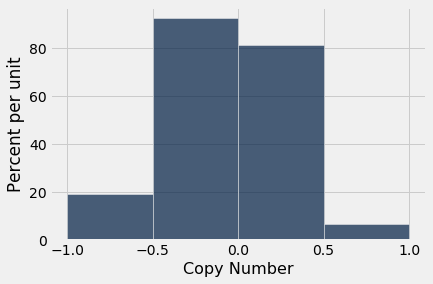

In [3]:
# Just run this cell
pten.hist("Copy Number", bins = np.arange(-1, 1.5, 0.5))

**Question 1**

Looking at the histogram above, we want to check whether or not `Copy Number` is in standard units. For this question, compute the mean and the standard deviation of the values in `Copy Number` and assign these values to `copy_number_mean` and `copy_number_sd` respectively. After you calculate these values, assign `is_su` to either `True` if you think that `Copy Numbers` is in standard units or `False` if you think otherwise.

*Hint: What would the mean and SD of an array in standard units be?*

<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [5]:
copy_number = pten.column("Copy Number")
copy_number_mean = np.mean(copy_number)
copy_number_sd = np.std(copy_number)
is_su = False
print(f"Mean: {copy_number_mean}, SD: {copy_number_sd}, Is in standard units?: {is_su}")

Mean: -0.19447913669064748, SD: 0.7462401942190691, Is in standard units?: False


In [6]:
ok.grade("q1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2**

Create the function `standard_units` so that it converts the values in the array `arr` to standard units. We'll then use `standard_units` to create a new table, `pten_su`, that converts all the values in the table `pten` to standard units.

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

In [7]:
def standard_units(arr):
    return (arr - np.mean(arr)) / np.std(arr)

# DON'T DELETE OR MODIFY ANY OF THE LINES OF CODE BELOW IN THIS CELL
pten_su = Table().with_columns("Cell Line", pten.column("Cell Line"),
                               "Copy Number SU", standard_units(pten.column("Copy Number")),
                               "mRNA Expression (Affy) SU", standard_units(pten.column("mRNA Expression (Affy)")),
                               "mRNA Expression (RNAseq) SU", standard_units(pten.column("mRNA Expression (RNAseq)"))                             
                              )
pten_su.show(5)

Cell Line,Copy Number SU,mRNA Expression (Affy) SU,mRNA Expression (RNAseq) SU
DMS53_LUNG,0.492173,-0.925344,-0.17077
SW1116_LARGE_INTESTINE,0.516562,-0.355245,0.0992261
NCIH1694_LUNG,-0.0572481,-0.492553,0.0656589
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.243325,1.17902,1.37408
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.21519,0.142045,0.0163913


In [8]:
ok.grade("q1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You should always visually inspect your data, before numerically analyzing any relationships in your dataset. Run the following cell in order to look at the relationship between the variables in our dataset.

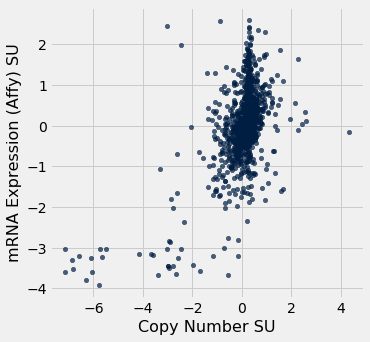

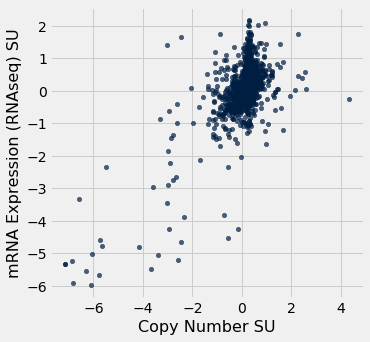

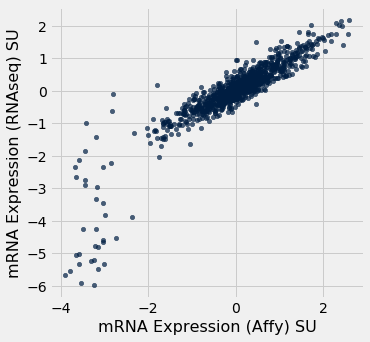

In [9]:
# Just run this cell
pten_su.scatter("Copy Number SU", "mRNA Expression (Affy) SU")
pten_su.scatter("Copy Number SU", "mRNA Expression (RNAseq) SU")
pten_su.scatter("mRNA Expression (Affy) SU", "mRNA Expression (RNAseq) SU")

**Question 3**

Which of the following relationships do you think has the highest correlation (i.e. highest absolute value of `r`)? Assign `highest_correlation` to the number corresponding to the relationship you think has the highest correlation.

1. mRNA Expression (Affy) vs. mRNA Expression (RNAseq)
2. Copy Number vs. mRNA Expression (RNAseq)
3. Copy Number vs. mRNA Expression (Affy)

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

In [10]:
highest_correlation = 1

In [11]:
ok.grade("q1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4**

Now, using the `standard_units` function, define the function `correlation` which computes the correlation between `arr1` and `arr2`.

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

In [12]:
def correlation(arr1, arr2):
    '''arr1 and arr2 will always be the same length.'''
    return np.mean( standard_units(arr1) * standard_units(arr2) )

# This computes the correlation between the different variables in pten
copy_affy = correlation(pten.column("Copy Number"), pten.column("mRNA Expression (Affy)"))
copy_rnaseq = correlation(pten.column("Copy Number"), pten.column("mRNA Expression (RNAseq)"))
affy_rnaseq = correlation(pten.column("mRNA Expression (Affy)"), pten.column("mRNA Expression (RNAseq)"))

print(f" \
      Copy Number vs. mRNA Expression (Affy) Correlation: {copy_affy}, \n \
      Copy Number vs. mRNA Expression (RNAseq) Correlation: {copy_rnaseq}, \n \
      mRNA Expression (Affy) vs. mRNA Expression (RNAseq) Correlation: {affy_rnaseq}")

       Copy Number vs. mRNA Expression (Affy) Correlation: 0.5819516653311988, 
       Copy Number vs. mRNA Expression (RNAseq) Correlation: 0.6954196009651351, 
       mRNA Expression (Affy) vs. mRNA Expression (RNAseq) Correlation: 0.9000764746535077


In [13]:
ok.grade("q1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 5**

If we switch what we input as arguments to `correlation`, i.e. found the correlation between `mRNA Expression (Affy)` vs. `Copy Number` instead of the other way around, would the correlation change? Assign `correlation_change` to either `True` if you think yes, or `False` if you think no.

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

In [14]:
correlation_change = False

In [15]:
ok.grade("q1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 6**

Looking at both the scatter plots after Question 2 and the correlations computed in Question 4, what similarities or differences do you see in the strength of the linear relationships?

<!--
BEGIN QUESTION
name: q1_6
manual: true
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

The third set of variables is most clearly linearly related, but all of the sets of variables have a high, positive linear association. 

**Question 7**

Let's look at the relationship between mRNA Expression (Affy) vs. mRNA Expression (RNAseq) only. Define a function called `regression_parameters` that returns the parameters of the regression line as a two-item array containing the slope and intercept of the regression line as the first and second elements respectively. The function `regression_parameters` takes in two arguments, an array of `x` values, and an array of `y` values.

Note: Feel free to use as many lines as needed to define the slope and interecept of `regression_parameters`.

*Hint: You should use a function you previously defined to calculate any intermediate quantities needed.*

<!--
BEGIN QUESTION
name: q1_7
manual: false
-->

In [16]:
def regression_parameters(x, y):
    corr = correlation(x, y)
    slope = corr * np.std(y) / np.std(x)
    intercept = np.mean(y) - slope * np.mean(x)
    return make_array(slope, intercept)

parameters = regression_parameters(pten.column("mRNA Expression (Affy)"), pten.column("mRNA Expression (RNAseq)"))
parameters

array([ 1.07113964, -6.45428385])

In [17]:
ok.grade("q1_7");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 8**

If we switch what we input as arguments to `regression_parameters`, i.e. found the parameters for the regression line for `mRNA Expression (RNAseq)` vs. `mRNA Expression (Affy)` instead of the other way around, would the regression parameters change (would the slope and/or intercept change)? Assign `parameters_change` to either `True` if you think yes, or `False` if you think no.

<!--
BEGIN QUESTION
name: q1_8
manual: false
-->

In [18]:
parameters_change = True

In [19]:
ok.grade("q1_8");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 9**

Now, let's look at how the regression parameters look like in standard units. Use the table `pten_su` and the function `regression_parameters`, and assign `parameters_su` to a two-item array containing the slope and the intercept of the regression line for mRNA Expression (Affy) in standard units vs. mRNA Expression (RNAseq) in standard units.


<!--
BEGIN QUESTION
name: q1_9
manual: false
-->

In [22]:
parameters_su = regression_parameters(pten_su.column("mRNA Expression (Affy) SU"), pten_su.column("mRNA Expression (RNAseq) SU"))
parameters_su

array([9.00076475e-01, 1.16123028e-16])

In [23]:
ok.grade("q1_9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



If you are unfamiliar with scientific notation, running the following cell will help you see the slope and intercept more clearly.

In [24]:
round(parameters_su.item(0), 2), round(parameters_su.item(1), 2)

(0.9, 0.0)

**Question 10**

Looking at the array `parameters_su`, what do you notice about the slope and intercept values specifically? Relate the slope to another value we already calculated in a previous question, as well as relate them to an equation of the regression line.


<!--
BEGIN QUESTION
name: q1_10
manual: true
-->
<!-- EXPORT TO PDF -->

The slope is the same as the correlation coefficient, and the intercept is 0. 

The oldest and most commonly used cell line in Biology is the HeLa cell line, named after Henrietta Lacks, whose cervical cancer cells were taken without her consent in 1951 to create this cell line. The issue of data privacy and consent is very important to data science.

There are many issues with this case regarding social, racial, and other ethical concerns, and we encourage you to read about them [here](https://www.hopkinsmedicine.org/henriettalacks/). Understanding where your data comes from, including how it was collected and who it was collected from, is extremely important in practicing careful and ethical data science.

**Question 11**

The HeLa cell line is missing from our dataset. Luckily, we now have the parameters of a regression line to predict HeLa mRNA Expression (RNAseq) value given a Hela mRNA Expression (Affy) value. Remember, this is significant because this is the goal of regression - to predict a value given another. If mRNA expression (Affy) = 8.2, what is our regression estimate of RNAseq? Use the values in `parameters` that we derived in Question 1.7, and assign the result to `hela_rnaseq`.

<!--
BEGIN QUESTION
name: q1_11
manual: false
-->

In [25]:
hela_rnaseq = parameters.item(0) * 8.2 + parameters.item(1)
hela_rnaseq

2.32906120281946

In [26]:
ok.grade("q1_11");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 12**

Compute the predicted mRNA Expression (RNAseq) values from the mRNA Expression (Affy) values in the `pten` table. Use the values in the `parameters` array from Question 1.7, and assign the result to `predicted_rnaseq`. We'll plot your computed regression line with the scatter plot from after question 1.2 of mRNA Expression (Affy) vs. mRNA Expression (RNAseq).

*Sanity Check: Given the strong correlation between the two variables, does your regression line make sense / have a good fit?*


<!--
BEGIN QUESTION
name: q1_12
manual: true
-->
<!-- EXPORT TO PDF -->

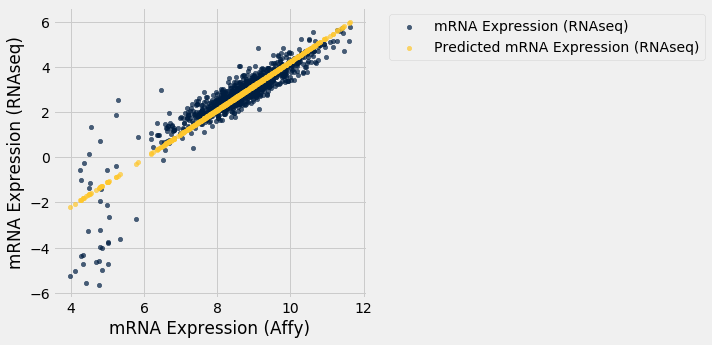

In [27]:
predicted_rnaseq = parameters.item(0) * pten.column("mRNA Expression (Affy)") + parameters.item(1)

# DON'T CHANGE/DELETE ANY OF THE BELOW CODE IN THIS CELL
(pten.with_column("Predicted mRNA Expression (RNAseq)", predicted_rnaseq)
 .select("mRNA Expression (Affy)", "mRNA Expression (RNAseq)", "Predicted mRNA Expression (RNAseq)")
 .scatter("mRNA Expression (Affy)"))
plt.ylabel("mRNA Expression (RNAseq)");

### Fitting a least-squares regression line

Recall that the least-square regression line is the unique straight line that minimizes root mean squared error (RMSE) among all possible fit lines. Using this property, we can find the equation of the regression line by finding the pair of slope and intercept values that minimize root mean squared error.

**Question 13**

Define a function called `RMSE_mRNA`. It should take two arguments:

1. the slope of a line (a number)
2. the intercept of a line (a number).

It should return a number that is the root mean squared error (RMSE) for a line defined with the arguments slope and intercept used to predict mRNA Expression (RNAseq) values from mRNA Expression (Affy) values for each row in the `pten` table.

*Hint: Errors are defined as the difference between the actual `y` values and the predicted `y` values.*

*Note: if you need a refresher on RMSE, here's the [link](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html#Root-Mean-Squared-Error) from the textbook*

<!--
BEGIN QUESTION
name: q1_13
manual: false
-->

In [30]:
def RMSE_mRNA(slope, intercept):
    affy = pten.column("mRNA Expression (Affy)")
    rnaseq = pten.column("mRNA Expression (RNAseq)")
    predicted_rnaseq = slope * affy + intercept
    return np.sqrt( np.mean((rnaseq - predicted_rnaseq) ** 2 ) )

# DON'T CHANGE THE FOLLOWING LINES BELOW IN THIS CELL
rmse_example = RMSE_mRNA(0.5, 6)
rmse_example

7.612008179226994

In [31]:
ok.grade("q1_13");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 14**

What is the RMSE of a line with slope 0 and intercept of the mean of `y` equal to?

*Hint 1: The line with slope 0 and intercept of mean of `y` is just a straight horizontal line at the mean of `y`*

*Hint 2: What does the formula for RMSE become if we input our predicted `y` values in the formula? Try writing it out on paper! It should be a familiar formula.*

<!--
BEGIN QUESTION
name: q1_14
manual: true
-->
<!-- EXPORT TO PDF -->

This is simply the standard deviation in $y$, i.e., the RMS deviations in $y$

**Question 15**

Find the parameters that minimizes RMSE of the regression line for mRNA Expression (Affy) vs. mRNA Expression (RNAseq). Assign the result to `minimized_parameters`.

If you haven't tried to use the `minimize` [function](https://math-121-spring-21.github.io/python-reference.html) yet, now is a great time to practice. Here's an [example from the textbook](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html#numerical-optimization).

*Hint: Use the `RMSE_mRNA` function in Question 1.13*

**NOTE: When you use the minimize function, please pass in `smooth=True` as the second argument to this function. You'll need to do this, otherwise, your answer will be incorrect**

<!--
BEGIN QUESTION
name: q1_15
manual: false
-->

In [34]:
minimized_parameters = minimize(RMSE_mRNA, smooth=True)
minimized_parameters

array([ 1.07113932, -6.4542811 ])

In [35]:
ok.grade("q1_15");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 16**

The slope and intercept pair you found in Question 1.15 should be very similar to the values that you found in Question 1.7. Why were we able to minimize RMSE to find the same slope and intercept from the previous formulas?


<!--
BEGIN QUESTION
name: q1_16
manual: true
-->
<!-- EXPORT TO PDF -->

Because the Least Squares line we found above is the one that minimizes RMSE.

**Question 17**

If we had instead minimized mean squared error (MSE), would we have gotten the same slope and intercept of the minimized root mean squared error (RMSE) results? Assign `same_parameters` to either `True` if you think yes, or `False` if you think no.


<!--
BEGIN QUESTION
name: q1_17
manual: false
-->

In [36]:
same_parameters = True
same_parameters

True

In [37]:
ok.grade("q1_17");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Let's look at the scatter plot of the relationship between mRNA Expression (Affy) and mRNA Expression (RNAseq) again:

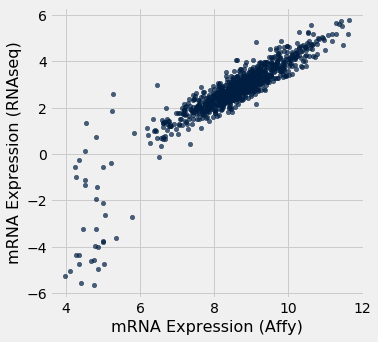

In [38]:
pten.scatter("mRNA Expression (Affy)", "mRNA Expression (RNAseq)")

**Question 18**

Using a linear regression model, would we be able to obtain accurate predictions of mRNA Expression (RNAseq) for most of the points? Explain why or why not.


<!--
BEGIN QUESTION
name: q1_18
manual: true
-->
<!-- EXPORT TO PDF -->

Yes, the data has a nice football shape, and a majority of the points cluster around a line.

## 2. Properties of Binary Distributions


Binary distributions arise in regular everyday life, and as data scientists you will encounter them constantly. A binary distribution is a distribution across two categories: such as voting in support of a proposition or voting against it on your local ballot, flipping heads or tails, having heart disease or not having heart disease. Generally we represent 'yes' or `True` as 1, and 'no' or `False` as 0. Binary distributions have some special properties that make working with them especially easy!

**The intent of this section of the homework is to walk you through these properties, so we decided to make all of the tests for this section public (i.e. there are no hidden tests to worry about for this section only).**

#### Question 1

Let's generate a random binary distribution of 0's and 1's. Assign `binary_options` to the correct array of possible values in a binary distribution (i.e. look at the previous sentence).


<!--
BEGIN QUESTION
name: q2_1
manual: false
-->

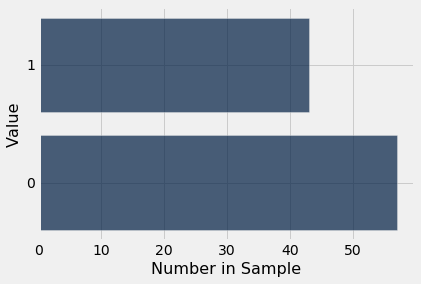

In [3]:
binary_options = make_array(0,1)


# DON'T DELETE/MODIFY ANY OF THE CODE IN THIS CELL BELOW
sample_size = 100
binary_sample = np.random.choice(binary_options, sample_size)

# Run this to see a bar chart of this random distribution.
Table().with_columns("Value", make_array(1, 0), "Number in Sample", make_array(sum(binary_sample), sample_size - sum(binary_sample))).barh("Value")

In [4]:
ok.grade("q2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2

The first property you should note is that the proportion of ones in a binary distribution is equal to the mean of the distribution. [Think about why this is true](https://www.inferentialthinking.com/chapters/14/1/Properties_of_the_Mean.html#Proportions-are-Means). Complete the following cell to show that this is the case for your `binary_sample`. Assign `number_of_ones` and `number_of_zeros` to the number of `1`'s and the number of `0`'s respectively from your `binary_sample`.


<!--
BEGIN QUESTION
name: q2_2
manual: false
-->

In [5]:
number_of_ones = np.count_nonzero(binary_sample == 1)
number_of_zeros = np.count_nonzero(binary_sample == 0)


# DON'T DELETE/MODIFY ANY OF THE CODE BELOW IN THIS CELL
number_values = len(binary_sample)
sum_of_binary_sample = sum(binary_sample)
# Remember that the mean is equal to the sum divided by the number of items
mean_binary_sample = sum_of_binary_sample / number_values

# Don't change this!
print(f"In your binary sample there were {number_of_ones} ones and {number_of_zeros} zeros. 1*{number_of_ones} + 0*{number_of_zeros} = {number_of_ones}")
print(f"The sum of values in your sample was {sum_of_binary_sample}, divided by the number of items, {number_values}, gives us a mean of {mean_binary_sample}")
print(f"The proportion of ones in your sample was {number_of_ones} ones, divided by the number of items, {number_values}, gives us a value of {mean_binary_sample}" )
print('Those values are equal!')

In your binary sample there were 43 ones and 57 zeros. 1*43 + 0*57 = 43
The sum of values in your sample was 43, divided by the number of items, 100, gives us a mean of 0.43
The proportion of ones in your sample was 43 ones, divided by the number of items, 100, gives us a value of 0.43
Those values are equal!


In [6]:
ok.grade("q2_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Since the proportion of ones is the same as the mean, the Central Limit Theorem applies! That is, if we resample our sample a lot of times, the distribution of the proportion of ones in our resamples will be roughly normal, with a predictable center and spread!

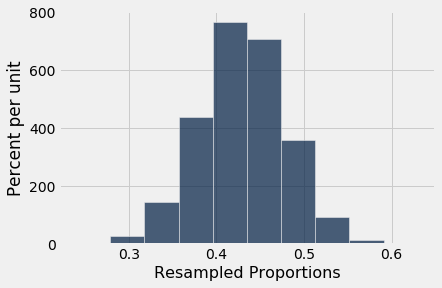

In [7]:
# Just run this cell
resampled_proportion_of_ones = make_array()

for i in np.arange(5000):
    resample = Table().with_column("Value", binary_sample).sample()
    resample_proportion_ones = resample.where("Value", 1).num_rows / resample.num_rows
    resampled_proportion_of_ones = np.append(resampled_proportion_of_ones, resample_proportion_ones)
    
Table().with_column('Resampled Proportions', resampled_proportion_of_ones).hist()

Let's generate a table where each row has a different number of ones and zeros that we'll use for the following parts.

In [8]:
# Just run this cell
possible_number_ones = np.arange(sample_size + 1)
possible_number_zeros = sample_size - possible_number_ones

possibilities_table = Table().with_columns("Values of One", possible_number_ones, "Values of Zero", possible_number_zeros)
possibilities_table.show(5)

Values of One,Values of Zero
0,100
1,99
2,98
3,97
4,96


#### Question 3
The second important property of binary distributions is that the standard deviation of every binary distribution is equal to:
$$\sqrt{\text{proportion_ones} *\text{proportion_zeros}}$$

While this property is useful in some cases, a more useful extension of this property is that it tells us that the maximum standard deviation for a binary distribution is 0.5!

Let's explore why that is the case!

Complete the `binary_std_formula` function below so that it returns the standard deviation of a binary distribution according to the formula above. The function takes in a `row` that looks like a row in `possibilities_table`. 


<!--
BEGIN QUESTION
name: q2_3
manual: false
-->

In [10]:
def binary_std_formula(row):
    num_ones = row.item("Values of One")
    num_zeros = row.item("Values of Zero")
    
    sum_ones_and_zeros = num_ones + num_zeros
    prop_ones = num_ones/ sum_ones_and_zeros
    prop_zeros = num_zeros / sum_ones_and_zeros
    return np.sqrt( prop_ones * prop_zeros )

# DON'T DELETE/MODIFY ANY OF THE LINES BELOW IN THIS CELL
possibilities_table = possibilities_table.with_column("Formula SD", possibilities_table.apply(binary_std_formula))
possibilities_table.show(5)

Values of One,Values of Zero,Formula SD
0,100,0
1,99,0.0994987
2,98,0.14
3,97,0.170587
4,96,0.195959


In [11]:
ok.grade("q2_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Here's another function that takes in a row object from a table, generates a sample that has the same number of ones and zeros as the row specifies, and then returns the standard deviation of that table. You should be able to understand exactly what this function does! It also does the same thing as above, where we return the standard deviation, but we just use `np.std` for this function.

In [12]:
# Just run this cell
def binary_std(row):
    values = make_array()
    for i in np.arange(row.item("Values of One")):
        values = np.append(values, 1)
    for i in np.arange(row.item("Values of Zero")):
        values = np.append(values, 0)
    return np.std(values)

possibilities_table = possibilities_table.with_column("Empirical SD", possibilities_table.apply(binary_std))
possibilities_table.show(5)

Values of One,Values of Zero,Formula SD,Empirical SD
0,100,0,0
1,99,0.0994987,0.0994987
2,98,0.14,0.14
3,97,0.170587,0.170587
4,96,0.195959,0.195959


All the values are the same! Let's see what this formula means!

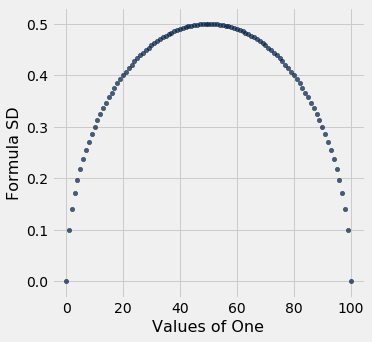

In [13]:
# Just run this cell
possibilities_table.scatter("Values of One", "Formula SD")

What a beautiful curve!

Looking at that curve, we can see that maximum value is $0.5$, which occurs in the middle of the distribution, when the two categories have equal proportions (proportion of ones = proportion of zeros = $\frac{1}{2}$).

## 3. Submission


Once you're finished, select "Save and Checkpoint" in the File menu and then execute the `submit` cell below. The result will contain a link that you can use to check that your assignment has been submitted successfully. If you submit more than once before the deadline, we will only grade your final submission. If you mistakenly submit the wrong one, you can head to [okpy.org](https://okpy.org/) and flag the correct version. To do so, go to the website, click on this assignment, and find the version you would like to have graded. There should be an option to flag that submission for grading!

In [60]:
_ = ok.submit()

In [61]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")